In [1]:
!pip install optuna -q
!pip install --upgrade datasets -q
!pip install --upgrade triton -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 4.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive') # mounting drive where files are stored

Mounted at /content/drive


In [3]:
import sys
path = "/content/drive/MyDrive/AI_Cybersecurity/Project/"
sys.path.append(path)

In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as F # loading libraries
from sklearn.datasets import load_iris
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, load_from_disk
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from contextlib import nullcontext
from utils import BPE_Tokenizer, KNN, train_model, test_model, run_inference_and_collect_results, calculate_auc_roc, plot_confusion_matrix, test_model_adversarial, run_inference_and_collect_results_adversarial, multiples_of_two

In [5]:
tokenizer = BPE_Tokenizer(directory=path+'Tokenizer')
vocab = tokenizer.vocab
vocab_size = len(vocab) + 1
print("Vocab size is", vocab_size)

Vocab size is 10007


In [6]:
tokenized_dataset = load_from_disk(path+"Datasets/FinalDataset/")

In [7]:
train_dataset = tokenized_dataset['train']
val_dataset = tokenized_dataset['validation']
test_dataset = tokenized_dataset['test']

In [8]:
batch_size = 128

# Prepare dataloaders for batching the data during training and evaluation
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

In [9]:
device = 'cpu'
num_metadata_features = len(train_dataset['metadata'][0])
max_context_size = 256

In [10]:
# Initialize the model for binary classification of class 0
model = KNN(max_context_size, num_metadata_features=num_metadata_features).to(device)

# Test the model with the initial untrained state and compute training loss
for batch in train_loader:
    inputs = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    metadata = batch["metadata"].to(device)
    labels = batch["label"].to(device)
    model.fit(inputs, attention_mask, metadata, labels)
    logits, _ = model(inputs, attention_mask, metadata, labels)  # Forward pass through the model
    print(logits.shape)
    break

torch.cuda.empty_cache()

loss = test_model(model, train_loader, fp16=True, device=device)  # Compute the loss on the training dataset
print(f"Initial Training Loss {loss:.4f}")

torch.Size([188636, 2])
Initial Training Loss 0.3186


In [11]:
def objective(trial):
    # Define KNN hyperparameters to optimize
    n_neighbors = trial.suggest_int("n_neighbors", 1, 100)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    metric = trial.suggest_categorical("metric", ["euclidean", "manhattan", "cosine", "minkowski"])
    p = trial.suggest_int("p", 1, 10)  # Power parameter for Minkowski metric
    leaf_size = trial.suggest_int("leaf_size", 1, 100)

    # Create the model
    model = KNN(
        context_size=max_context_size,
        num_metadata_features=num_metadata_features,
        n_neighbors=n_neighbors,
        weights=weights,
        metric=metric,
        p=p,
        leaf_size=leaf_size,
    )

    # Test the model with the initial untrained state and compute training loss
    for batch in train_loader:
        inputs = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        metadata = batch["metadata"].to(device)
        labels = batch["label"].to(device)
        model.fit(inputs, attention_mask, metadata, labels)

    # Evaluate on the validation set
    val_loss = test_model(model, val_loader, device, fp16=True)

    # Return the validation loss as the objective to minimize
    return val_loss

In [ ]:
# Create an Optuna study
study = optuna.create_study(direction="minimize")

# Run the optimization
study.optimize(objective, n_trials=50)

[I 2024-12-07 18:32:45,414] A new study created in memory with name: no-name-45f0a599-0b54-48b0-acc6-e6966c665944
[I 2024-12-07 18:42:43,724] Trial 0 finished with value: 0.32721251249313354 and parameters: {'n_neighbors': 79, 'weights': 'distance', 'metric': 'manhattan', 'p': 9, 'leaf_size': 65}. Best is trial 0 with value: 0.32721251249313354.
[I 2024-12-07 18:43:57,032] Trial 1 finished with value: 0.3342250883579254 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'euclidean', 'p': 3, 'leaf_size': 32}. Best is trial 0 with value: 0.32721251249313354.
[I 2024-12-07 18:45:08,870] Trial 2 finished with value: 0.32068586349487305 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'euclidean', 'p': 9, 'leaf_size': 90}. Best is trial 2 with value: 0.32068586349487305.
[I 2024-12-07 18:47:17,871] Trial 3 finished with value: 0.32587864995002747 and parameters: {'n_neighbors': 86, 'weights': 'distance', 'metric': 'cosine', 'p': 8, 'leaf_size': 84}. Best 

Best hyperparameters:
n_neighbors: 1
weights: uniform
metric: euclidean
p: 5
leaf_size: 75


In [12]:
# Print the best hyperparameters
print("Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

Best hyperparameters:
n_neighbors: 1
weights: uniform
metric: euclidean
p: 5
leaf_size: 75


In [13]:
n_neighbors = 1
weights = 'uniform'
metric = 'euclidean'
p = 5
leaf_size = 75

In [14]:
model = KNN(context_size=max_context_size,                  # Length of token sequences (T)
        num_metadata_features=num_metadata_features,    # Number of metadata features (optional)
        n_neighbors=5,                 # Number of neighbors
        weights="uniform",             # Weight function ("uniform" or "distance")
        metric="euclidean",            # Distance metric
        p=5,                           # Power parameter for Minkowski metric
        leaf_size=75)

# Test the model with the initial untrained state and compute training loss
for batch in train_loader:
    inputs = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    metadata = batch["metadata"].to(device)
    labels = batch["label"].to(device)
    model.fit(inputs, attention_mask, metadata, labels)

In [15]:
test_results = run_inference_and_collect_results(model, test_loader, device, fp16=True)
test_loss = test_model(model, test_loader, device, fp16=False)

accuracy = accuracy_score(test_results['Predicted Outputs'], test_results['True Labels']) * 100
precision = precision_score(test_results['True Labels'], test_results['Predicted Outputs'])
recall = recall_score(test_results['True Labels'], test_results['Predicted Outputs'])
f1 = f1_score(test_results['True Labels'], test_results['Predicted Outputs'])

print(f'Final Test Loss: {test_loss:.4f}')
print(f"Final Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Final Test Loss: 0.3208
Final Accuracy: 99.26%
Precision: 0.99
Recall: 1.00
F1 Score: 0.99


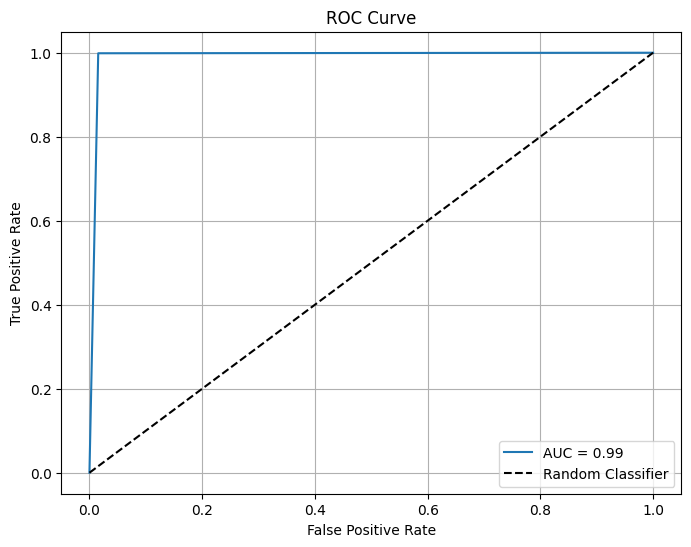

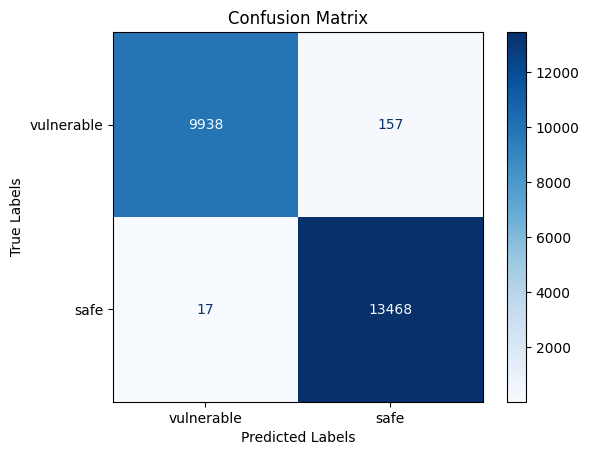

The Area Under Curve (AUC) is: 0.99


In [16]:
auc = calculate_auc_roc(model, test_loader, device)
plot_confusion_matrix(model, test_loader, device)
print(f'The Area Under Curve (AUC) is: {auc:.2f}')

In [17]:
adversarial_tokenized_dataset = load_from_disk(path+"Datasets/TransformedDataset/")

adversarial_train_dataset = adversarial_tokenized_dataset['train']
adversarial_val_dataset = adversarial_tokenized_dataset['validation']
adversarial_test_dataset = adversarial_tokenized_dataset['test']

batch_size = 128

# Prepare dataloaders for batching the data during training and evaluation
adversarial_train_loader = DataLoader(adversarial_train_dataset, batch_size=batch_size, shuffle=True)
adversarial_val_loader = DataLoader(adversarial_val_dataset, batch_size=batch_size, shuffle=True)
adversarial_test_loader = DataLoader(adversarial_test_dataset, batch_size=batch_size, shuffle=True)

In [18]:
adversarial_losses = test_model_adversarial(model, adversarial_test_loader, device, fp16=True)
adversarial_results = run_inference_and_collect_results_adversarial(model, adversarial_test_loader, device, fp16=True)

In [19]:
print("Adversarial Losses:")
print(f"Original Loss: {adversarial_losses['original_loss']:.4f}")
print(f"Similar Characters Loss: {adversarial_losses['similar_loss']:.4f}")
print(f"Case Symbols Loss: {adversarial_losses['case_symbols_loss']:.4f}")
print(f"Unicode Replacement Loss: {adversarial_losses['unicode_loss']:.4f}\n")

# Evaluate metrics for each type
for key in adversarial_results:
    predictions = adversarial_results[key]["predictions"]
    labels = adversarial_results[key]["labels"]

    accuracy = accuracy_score(labels, predictions) * 100
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    print(f"Results for {key.capitalize()} Inputs:")
    print(f"  Accuracy: {accuracy:.2f}%")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1 Score: {f1:.2f}")
    print("\n")

Adversarial Losses:
Original Loss: 0.3209
Similar Characters Loss: 0.4322
Case Symbols Loss: 0.3218
Unicode Replacement Loss: 0.5462

Results for Original Inputs:
  Accuracy: 99.26%
  Precision: 0.99
  Recall: 1.00
  F1 Score: 0.99


Results for Similar Inputs:
  Accuracy: 87.88%
  Precision: 0.93
  Recall: 0.86
  F1 Score: 0.89


Results for Case symbols Inputs:
  Accuracy: 99.22%
  Precision: 0.99
  Recall: 1.00
  F1 Score: 0.99


Results for Unicode Inputs:
  Accuracy: 75.58%
  Precision: 0.87
  Recall: 0.68
  F1 Score: 0.76


